## Задание 11

В этом задании мы рассмотри несколько прикладных задач теории сложных сетей. 

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import mmread
from tqdm.notebook import tqdm
%matplotlib inline
import networkx as nx
from imdb import IMDb
import seaborn as sns

In [4]:
ia = IMDb()

### 1. Разложение по k-core и визуализация сложной сети (4  балла)
#### Определение 1.  
$k$-core -  подграф графа $G(V,E)$, в котором все вершины имеют степень не ниже $k$. 

Рассмотрим простой пример:

In [5]:
G=nx.read_edgelist('../data/k-core-exp.txt', nodetype=int)

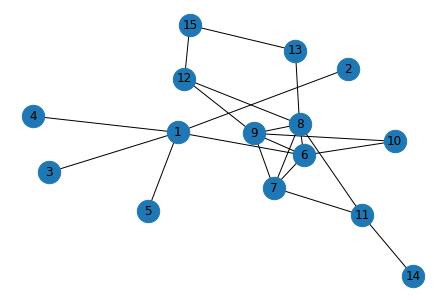

In [6]:
pos=nx.spring_layout(G,iterations=10)
colors=['b']*G.number_of_nodes() # цвет вершин
nx.draw(G,pos,node_size=500,with_labels=True)
limits=plt.axis('off') 

Найдем $k$-core для разных значений $k$ и выделим цветом вершины в соответсвующем $k$-core: 

In [7]:
kG=nx.k_core(G,k=2) #для k=2, по умолчанию наибольший k
print(kG.nodes())
for node in kG.nodes:
    colors[node-1]='g'

[6, 7, 8, 9, 10, 11, 12, 13, 15]


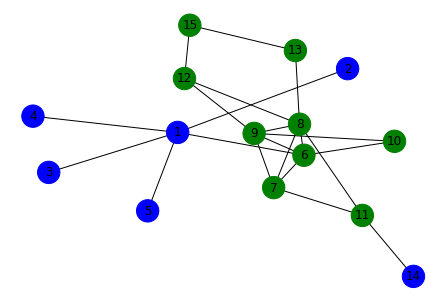

In [8]:
nx.draw(G,pos,node_size=500,node_color=colors,with_labels=True)

[8, 9, 6, 7]


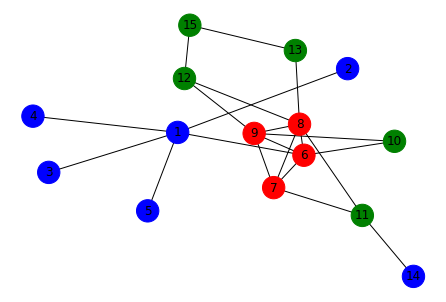

In [9]:
kG=nx.k_core(G,k=3) #для k=3
print(kG.nodes())
for node in kG.nodes:
    colors[node-1]='r'
    
nx.draw(G,pos,node_size=500,node_color=colors,with_labels=True)

Разложение по $k$-core - это поиск всех возможных $k$-core. 

Будем представлять каждое разложение в виде зависимости доли вершин, входящих в соответсвующий $k$-core от значения $k$ (график). 

 * Для выбранной [сети](http://networkrepository.com/) постройте разложение по $k$-core. Рандомизируйте сеть, сохраняя степени вершин. Как изменилась кривая разложения $k$-core? Какие выводы можно сделать? 
 

In [10]:
! cd ../data/ && unzip ca-hollywood-2009.zip 

Archive:  ca-hollywood-2009.zip
replace ca-hollywood-2009.mtx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [22]:
df_imdb = pd.read_csv('ca-IMDB.edges', skiprows=3, header=None, sep=' ', names=['source', 'target'])

In [23]:
G_imdb = nx.from_pandas_edgelist(df_imdb)

In [34]:
G_imdb.remove_edges_from(nx.selfloop_edges(G_imdb))

In [62]:
G_imdb_sw = nx.double_edge_swap(G_imdb, nswap=1000000, max_tries=1e+10, seed=42)

In [71]:
max_k = max(nx.core_number(G_imdb).items(), key=lambda x:x[-1])[-1]

In [73]:
k_cores = []
for k in tqdm(range(2, max_k)):
    k_cores.append(nx.k_core(G_imdb, k=k))

In [74]:
k_cores_sw = []
for k in tqdm(range(1, max_k)):
    k_cores_sw.append(nx.k_core(G_imdb_sw, k=k))

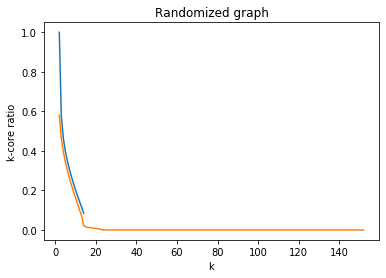

In [76]:
partitions_sw = [core.number_of_nodes()/G_imdb.number_of_nodes() for core in k_cores_sw]
partitions = [core.number_of_nodes()/G_imdb.number_of_nodes() for core in k_cores]
x_sw = np.arange(2, 2+len(partitions_sw))
sns.lineplot(x_sw, partitions_sw)
sns.lineplot(x, partitions)
plt.title('Randomized graph')
plt.xlabel('k')
plt.ylabel('k-core ratio')
plt.show()

#### Определение 2.
$k$-shell - подграф, содержащий вершины, которые входят в $k$-core, но не входят в $(k+1)$ - core. Например, синие вершины образуют $1$-shell, зеленые - $2$-shell. 

* Напишите функцию визуализации сети устроенной следующим образом. Вершины наибольшего $k_{max}$-shell расположены на окружности наименьшего радиуса, на окружности чуть большего радиуса расположите вершины $(k_{max}-1)$-shell и т.д. На внешней окружности наибольшего радиуса расположены вершины $1$-shell. 

### 2.  Предсказание связей в сложных сетях. 
Задача предсказания связей формулируется следующим образом. Пусть есть граф $G(V,E)$. По топологическим характеристикам вершин сети предсказать между какими парами вершин с большей вероятностью сформируются связи. 
Классически предполагается, что связи формируются у схожих вершин. Одну метрику схожести вершин мы обсуждали недавно, сегодня мы познакомимся еще с некоторыми метриками. 
Введем следующие обозначения:

$Г(x)$ - множество ближайших соседей вершины $x$,

$Г(y)$ - множество ближайших соседей вершины $y$,

$k(x)$ - степень вершины $x$,

$k(y)$ - степень вершины $y$.

Мы считаем, что связи между вершинами $x$ и $y$ нет. 

1. Число общих соседей
$$
s_{xy}=\left|Г(x)\cap Г(y)\right|
$$

2. Индекс Салтона
$$
s_{xy}=\frac{\left|Г(x)\cap Г(y)\right|}{\sqrt{k(x)k(y)}}
$$
3. Коэффициент Жаккара
$$
s_{xy}=\frac{\left|Г(x)\cap Г(y)\right|}{\left|Г(x)\cup Г(y)\right|}
$$
4. Коэффициент Серенсена
$$
s_{xy}=\frac{2\left|Г(x)\cap Г(y)\right|}{k(x)+k(y)}
$$

5. Коэффициент предпочтительного присоединения
$$
s_{xy}=\left|Г(x)\right| \cdot \left|Г(y)\right|
$$

6. Коэффициент Адамика-Адара

$$
s_{xy}=\sum_{z\in Г(x)\cap Г(y)} \frac{1}{\log k(z)}
$$

Вычисления некоторых коэффициентов реализовано в [NetworkX](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_prediction.html).

* Будем работать с сетью персонажей книг "A Song of Ice and Fire" (G.R.R. Martin) (см. задание 02). 
Постройте сеть по первой книге и вычислите соответсвующие коэффициенты близости для пар вершин между которыми нет ребра. 
По каждому коэффициенту выберите топ-10 пар вершин с наибольшими значениями (это будут ваши предсказания). Сравните предсказания между собой? Похожи ли они? 

* Загрузите сети по следующим книгам, появились ли связи между персонажами, которые вы предсказали? 

* (дополнительно +2 балла) попробуйте переопределить коэффициенты для взвешенной сети, как изменятся ваши предсказания, если учесть веса в сети? 